# Evaluating Curriculum Rigor
## Background
In my experience with high school curriculum, I have found a wide variation in the rigor of course material.  This project seeks to develop a tool for evaluating the rigor of a curriculum, by measuring its alignment to the College Board's respective AP Course.  This project focuses on the College Board's AP Computer Science A course, which covers a first year Java and Object Orientied Design course.

For this course, the College Board defines a set of "Computational Thinking Practices" (skills) and content that will be assessed on a year-end summative assessment to determine student's mastery of the course.   

There are 5 main Computational Thinking Practices identified by the College Board, which it then breaks down into subskills:  

<img src="Reports/Images/Skills-List.png" width=600px> 

In addition, the College Board defines a set of "Essential Knowledge" (the content) to be assessed in the course, which it organizes under 5 "Big Ideas."  For example, the content for a lesson on iteration is: 

<img src="Reports/Images/Content-Sample.png" width=400px>

Every question on the College Board's end-of-course summative exam is aligned to a particular computational thinking skill and essential knowledge.  As a note, some school networks have found the College Board's standards to be very complete, and "backwards plan" their middle school and pre-AP high school courses to prepare students for the AP level work. 

As a first step, this project will focus on the assessment questions used in a particular curriculum, and measure how well they align to the College Board's Computational Thinking Practice and Curriculum Framework.  (As a note, AP classes in most subjects have an analagous set of  thinking practices and framework standards, so one day, this work may be generalized to assess curriculums in other subject areas.)

The three questions to assess are:  

1. How accurately does a simple classifier using either a TF-IDF or SentenceTransformer vectorizer identify the Computational Thinking Practice assessed in a question?  
2. How accurately does ChatGPT, supplied with only the College Board Framework for Computational Thinking and a few sample questions, identify the Computational Thinking Practice assessed in a question?  
3. Can a useful Dashboard be created to improve the quality of an assessment question?

### Initial Conclusions:
1. The classifier using a TF-IDF vectorization accurately identified the Computational Thinking Practice being accessed in 70% of the questions, while the simple classifier using the Sentence Transformed identified the Computational Thinking Practice being assessed in 85% of the questions. 
2. ChatGPT had an accuracy of 48% in identifying the Computational Thinking Practice assessed in a question.

### Next Steps:
1. Develop better prompts to improve ChatGPT's classification accuracy.
2. Determine whether the classifier can also identify the "Essential Knowledge" assessed by the question, not just the computational skill.
3. Attempt to generalize the classifiers to classify non-assessment questions such as lecture material, lab questions, and homework problems.
4. Create a visualization that shows the distribution of thinking skills and content assessed over the course of the curriculum.

## Classifying Questions Using Logistic Regression
As first step, this section will try to classify prompts as assessing one of these two AP Computational Thinking Practices (CTP):
1. **CTP 2.A**: Apply the meaning of specific operators.  For example:  
*Consider the following code segment.*  
```
int x = 7;  
int y = 3;  
if ((x < 10) && (y < 0))  
  System.out.println(""Value is: "" + x * y);  
else  
  System.out.println(""Value is: "" + x / y) 
```
*What is printed as a result of executing the code segment?*

2. **CTP 2.B**: Determine the results or output based on statement execution order in a code segment without method calls (except for output).  For example:  

*Consider the following code segment.* 
```
int[] arr = {7, 2, 5, 3, 0, 10};  
for (int k = 0; k < arr.length - 1; k++)  {  
  if (arr[k] > arr[k + 1])  
    System.out.print(k + "" "" + arr[k] + "" "");  
} 
``` 
*What will be printed as a result of executing the code segment?*  

## Preprocessing the Data
In this first step, we will:
1. Load questions assessing each Computational Thinking Practice.
2. Filter the question set to only consider the most frequently assessed Computational Thinking Practices.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [6]:
df = pd.read_csv("Data/synthetic_all_questions.csv")
df_2014 = pd.read_csv("Data/CollegeBoard/SamplePrompts-PracticeExam2014.csv")
df_2014 = df_2014[["text","Classification"]]
df_2014.columns=["Question","Classification"]
df = pd.concat([df, df_2014])

In [7]:
df["Classification"] = df["Classification"].str.strip(" ':")
df = df[df["Classification"].isin(["1.B", "2.A", "2.B", "2.C", "2.D", "4.A", "5.A", "5.B"])]

## Testing the Logistic Regression Classifier on the Questions
Here, we build and evaluate a classifier that vectorizes questions using the TF-IDF vectorizer, and classifies using a Logistic Regression Classifier.  

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import nltk

In [12]:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    temp = tokenizer.tokenize(text.lower())
    return [lemmatizer.lemmatize(w) for w in temp]

stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("ha")
stopwords.append("doe")
stopwords.append("wa")

pipeline = [("tfidf",TfidfVectorizer(strip_accents='ascii', tokenizer=lemmatize_text, stop_words=stopwords, max_features=15, token_pattern=None)),
            ("lr", LogisticRegression(solver="saga", max_iter=10000))]
pipe = Pipeline(steps=pipeline)

params = [{"tfidf__max_features":[5,50,100], "lr__penalty":['l1', 'l2'],"lr__C":[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]}]
gs = GridSearchCV(estimator=pipe, param_grid=params)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df["Question"], df["Classification"], stratify=df["Classification"])
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=15,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...],
                                                        strip_accents='ascii',
                                                        token_pattern=None,
                                                        tokenizer=<function lemmatize_text at 0x1557d1120>)),
                                       ('lr',
                                        LogisticRegression(max_iter=10000,
                                                           solver='saga'))]),
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                                    10000.0],
                          'lr__penalty': ['l1', 'l2'],
                          'tfidf__max_features': [5, 50, 100]}])

In [14]:
y_test_pred = gs.predict(X_test)
print(classification_report(y_test, y_test_pred))
con_mat = confusion_matrix(y_test, y_test_pred)

              precision    recall  f1-score   support

         1.B       0.67      0.80      0.73         5
         2.A       0.75      1.00      0.86         3
         2.B       1.00      0.75      0.86         4
         2.C       0.50      0.25      0.33         4
         2.D       1.00      1.00      1.00         3
         4.A       0.20      0.50      0.29         2
         5.A       1.00      0.67      0.80         3
         5.B       1.00      0.50      0.67         2

    accuracy                           0.69        26
   macro avg       0.76      0.68      0.69        26
weighted avg       0.77      0.69      0.70        26



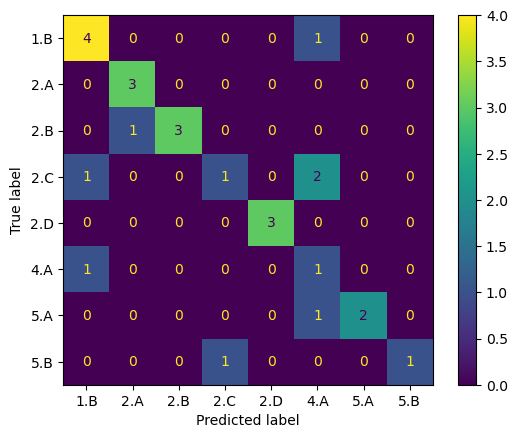

In [25]:
cm = ConfusionMatrixDisplay(con_mat, display_labels=gs.best_estimator_.classes_).plot()
cm.figure_.savefig("Reports/Images/LR_ConfusionMatrix.png")

### Interpreting the Logistic Classifier to Identify Key Features
Determine the most significant works for identifying each question.

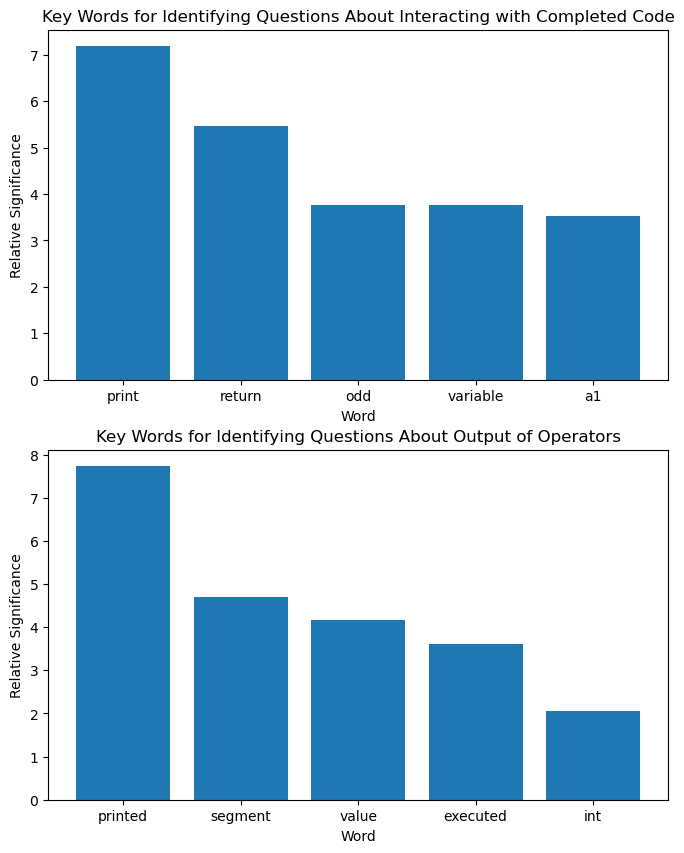

In [54]:
voc = {}
for x in gs.best_estimator_["tfidf"].vocabulary_:
    voc[gs.best_estimator_["tfidf"].vocabulary_[x]] = x
voc={k: v for k, v in sorted(gs.best_estimator_["tfidf"].vocabulary_.items(), key=lambda item: item[1])}
#pipe["lr"].coef_[0]

key_features = list(zip(list(voc.keys()), gs.best_estimator_["lr"].coef_[0]))

key_features.sort(key=lambda x: x[1], reverse=True);

fig, ax = plt.subplots(2,1, figsize=(8,10))

features = [x[0] for x in key_features[0:5]]
significance = [x[1] for x in key_features[0:5]]
ax[0].bar(features, significance)
ax[0].set_title("Key Words for Identifying Questions About Interacting with Completed Code");
ax[0].set_xlabel("Word");
ax[0].set_ylabel("Relative Significance");

key_features = list(zip(list(voc.keys()), gs.best_estimator_["lr"].coef_[1]))
key_features.sort(key=lambda x: x[1], reverse=True);

features = [x[0] for x in key_features[0:5]]
significance = [x[1] for x in key_features[0:5]]
ax[1].bar(features, significance)
ax[1].set_title("Key Words for Identifying Questions About Output of Operators");
ax[1].set_xlabel("Word");
ax[1].set_ylabel("Relative Significance");


### Using Model to Build a Question Classifier Tool
Here, a teacher can write a question, and the tool will classify the skills being assessed:

In [60]:
my_question = """ 
The method findMin(int a) below has been written to find the smallest number in a list of numbers.  Which of the following function
calls to findMin will show there is an error in the code? (A) findMin(5), (B) findMin(7), (C) findMin(1), (D) findMin(0)
"""
results = gs.predict_proba([my_question])
results = list(zip(gs.best_estimator_.classes_, results[0]))
results.sort(key=lambda x:x[1], reverse=True)
results

[('2.C', 0.6038800523277152),
 ('1.B', 0.08747366488858893),
 ('5.A', 0.07436605457702102),
 ('5.B', 0.06829595662636705),
 ('4.A', 0.061014560800013024),
 ('2.B', 0.04068396185484098),
 ('2.D', 0.038813509340998205),
 ('2.A', 0.025472239584455474)]

## Classification with Sentence Transformer Encoding
Next, the questions will be vectorized using a Sentence Transformer Embedding, which may capture some of the semantics in the question lost in the earlier TF-IDF vectorier.  

In [61]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

In [62]:
X_train_encode = model.encode(X_train.to_numpy())
X_test_encode = model.encode(X_test.to_numpy())

In [63]:
lr = LogisticRegression(solver='saga', max_iter=10000)
params = [{"penalty":['l1','l2'], 'C':[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]}]
search = GridSearchCV(estimator=lr, param_grid=params)

search.fit(X_train_encode, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                                10000.0],
                          'penalty': ['l1', 'l2']}])

In [64]:
y_test_pred = search.predict(X_test_encode)

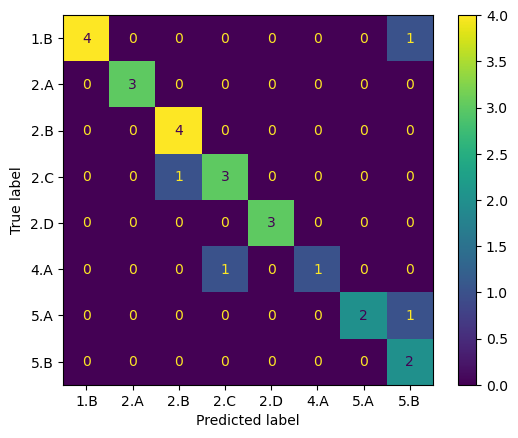

In [65]:
cm = confusion_matrix(y_test, y_test_pred);
ConfusionMatrixDisplay(cm, display_labels=search.best_estimator_.classes_).plot();

In [66]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.B       1.00      0.80      0.89         5
         2.A       1.00      1.00      1.00         3
         2.B       0.80      1.00      0.89         4
         2.C       0.75      0.75      0.75         4
         2.D       1.00      1.00      1.00         3
         4.A       1.00      0.50      0.67         2
         5.A       1.00      0.67      0.80         3
         5.B       0.50      1.00      0.67         2

    accuracy                           0.85        26
   macro avg       0.88      0.84      0.83        26
weighted avg       0.89      0.85      0.85        26



In [67]:
my_question = """ 
The method findMin(int a) below has been written to find the smallest number in a list of numbers.  Which of the following function
calls to findMin will show there is an error in the code? (A) findMin(5), (B) findMin(7), (C) findMin(1), (D) findMin(0)
"""
results = search.predict_proba([model.encode(my_question)])
results = list(zip(search.best_estimator_.classes_, results[0]))
results.sort(key=lambda x:x[1], reverse=True)
results


[('4.A', 0.8061548),
 ('1.B', 0.086053886),
 ('5.B', 0.068511195),
 ('2.C', 0.024228672),
 ('5.A', 0.009655114),
 ('2.B', 0.0029592994),
 ('2.A', 0.0013785751),
 ('2.D', 0.001058582)]

## Build and Test a ChatGPT Classifier

This classifier asks ChatGPT to determine the Computational Thinking Skill being assessed in the problem.  
1.  Create a function call to ask ChatGPT for the classification
2.  Test ChatGPT on data set and evaluate classification.

In [70]:
import pandas as pd
from openai import OpenAI
import os

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [71]:
prompt_start = """
Here are the categories for AP questions. 
1.B: Determine code that would be used to complete code segments 
1.C: Determine code that would be used to interact with completed program code. 
2.A: Apply the meaning of specific operators 
2.B: Determine the result or output based on statement execution order in a code segment without method calls (other than output) 
2.C: Determine the result or output based on the statement execution order in a code segment containing method calls. 
2.D: Determine the number of times a code segment will execute. 
4.A: Use test-cases to find errors or validate results. 
4.B: Identify errors in program code. 
4.C: Determine if two or more code segments yield equivalent results. 
5.A: Determine the behavior of a given segment of program code. 
5.B: Explain why a code segment will not compile or work as intended 
5.C: Explain how the result of program code changes, given a change to the initial code. 
5.D: Describe the initial conditions that must be met for a program segment to work as intended or described. 

Below are three example questions for each category 
1.B: Consider  the mode  method,  which  is intended  to return  the most  frequently  occurring  value  (mode ) in its int[]  parameter  arr. For example,  if the parameter  of the mode  method  has the contents  {6,5, 1, 5, 2, 6, 5}, then the method  is intended  to return  5. /** Precondition: arr.length  >= 1 */ public  static  int mode(int[]  arr)  { int modeCount  = 1; int mode  = arr[0];  for (int  j = 0; j < arr.length;  j++)  { int valCount  = 0; for (int  k = 0; k < arr.length;  k++)  { if ( /* missing  condition  1 */ ) { valCount++;  } } if ( /* missing  condition  2 */ ) { modeCount  = valCount;  mode  = arr[j];  } } return  mode;  } Which  of the following  can replace  /* missing  condition  1 */ and /* missing  condition  2 */ so the code  segment  works  as intended?  /* missing  condition  1 */ /* missing  condition  2 */ (A) arr[j]  == arr[k]  valCount  > modeCount  (B) arr[j]  == arr[k]  modeCount  > valCount  (C) arr[j]  != arr[k]  valCount  > modeCount  (D) arr[j]  != arr[k]  modeCount  > valCount 
1.B: Which  of the following  code segments  produces  the output  "987654321 " ? (A) int num = 10; while  (num  > 0) { System.out.print(num);  num--;  } (B) int num = 10; while  (num  >= 0) { System.out.print(num);  num--;  } (C) int num = 10; while  (num  > 1) { num--;  System.out.print(num);  } (D) int num = 10; while  (num  >= 1) { num--;  System.out.print(num);  } 
1.B: Consider  the following  method   which  is intended  to print  the values  in its two-dimensional  integer  array  parameter  in row-major  order.  public  static  void  rowMajor(int[][]  arr)  { /* missing  code  */ } As an example   consider  the following  code  segment.  int[][]  theArray  = {{1   2}  {3  4}  {5  6}  {7  8}};  rowMajor(theArray);  When  executed   the code  segment  should  produce  the following  output.  12345678  GO ON TO THE NEXT  PAGE.  AP Computer Science A Practice Exam 33 Which  of the following  code segments  can replace  /* missing  code  */ so that the rowMajor  method  works  as intended?  (A) for (int  j : arr)  { for (int  k : j) { System.out.print(j  + ""); } } (B) for (int  j : arr)  { for (int  k : j) { System.out.print(k  + ""); } } (C) for (int[]  j : arr)  { for (int  k : j) { System.out.print(j  + ""); } } (D) for (int[]  j : arr)  { for (int  k : j) { System.out.print(k  + ""); } } 
1.C: Consider  the following  class  definition.  public  class  Value  { private  int num;  public  int getNum()  { return  num;  } // There  may be instance  variables,  constructors,  and methods  not shown.  } The following  method  appears  in a class  other  than Value . It is intended  to sum all the num instance  variables  of the Value  objects  in its ArrayList  parameter.  /** Precondition: valueList  is not null  */ public  static  int getTotal(ArrayList<Value>  valueList)  { int total  = 0; /* missing  code  */ return  total;  } Which  of the following  code  segments  can replace  /* missing  code  */ so the getTotal  method  works  as intended?  I. for (int  x = 0; x < valueList.size();  x++)  { total  += valueList.get(x).getNum();  } II. for (Value  v : valueList)  { total  += v.getNum();  } III. for (Value  v : valueList)  { total  += getNum(v);  } (A) I only (B) II only (C) III only (D) I and II
1.C: Which of the following statements assigns a random integer between 25 and 60, inclusively, to rn? (A) int rn = (int)(Math.random()*25)+36; (B) int rn = (int)(Math.random()*25)+60; (C)int rn = (int)(Math.random())*26)+60; (D)int rn = (int)(Math.random())*36+25;(E)int rn=(int)(Math.random()*60+25);
1.C: Consider the following class definition. public class Example{ private int x;//constructor not shown} Which of the following is a correct header for a method of the Example class that would return the value of the private instance variable x so that it can be used in a class other than Example?
2.A: Consider  the following  code  segment.  Assume  num is a properly  declared  and initialized  int variable.  if (num  > 0) { if (num  % 2 == 0) { System.out.println( "A"); } else  { System.out.println( "B"); } } Which  of the following  best describes  the result  of executing  the code  segment?  (A) When  num is a negative  odd integer,  "B" is printed;  otherwise,  "A" is printed.  (B) When  num is a negative  even  integer,  "B" is printed;  otherwise,  nothing  is printed.  (C) When  num is a positive  even  integer,  "A" is printed;  otherwise,  "B" is printed.  (D) When  num is a positive  even  integer,  "A" is printed;  when  num is a positive  odd integer,  "B" is printed;  otherwise,  nothing  is printed.
2.A: Consider the following code segment.  int a=5; int b=2; double c=3.0; System.out.println(5+a/b*c-1); What is printed when the code segment is executed? (A) 0.6666666667 (B) 9.0  (C) 10.0  (D) 11.5  (E) 14.0
2.A: Consider the following code segment. int x = 7;  int y = 3;  if ((x < 10) && (y < 0))  System.out.println("Value is: " + x * y);  else  System.out.println("Value is: " + x / y);  What is printed as a result of executing the code segment? (A) Value is: 21 (B) Value is: 2.3333333 (C) Value is: 2 (D) Value is: 0 
2.B: Consider  the following  code segment.  int[][]  values  = {{1,  2, 3}, {4, 5, 6}};  int x = 0; for (int  j = 0; j < values.length;  j++)  { for (int  k = 0; k < values[0].length;  k++)  { if (k == 0) { values[j][k]  *= 2; } x += values[j][k];  } } What  is the value  of x after the code segment  is executed?  (A) 7 (B) 17 (C) 21 (D) 26
2.B: Consider the following code segment. int[] arr = {7  2  5  3  0  10};  for (int k = 0; k < arr.length - 1; k++)  {  if (arr[k] > arr[k + 1])  System.out.print(k + " " + arr[k] + " ");  }  What will be printed as a result of executing the code segment? (A) 0  2  2  3  3  0  (B) 0  7  2  5  3  3  (C) 0  7  2  5  5  10  (D) 1  7  3  5  4  3  
2.B: Consider the following code segment. int[] arr = {1  2  3  4  5  6  7};  for (int k = 3; k < arr.length - 1; k++)  arr[k] = arr[k + 1];  Which of the following represents the contents of  arr as a result of executing the code segment? (A) {1  2  3  4  5  6  7} (B) {1  2  3  5  6  7} (C) {1  2  3  5  6  7  7} (D) {1  2  3  5  6  7  8} 
2.C: Consider  the following  code segment.  ArrayList<Integer>  numList  = new ArrayList<Integer>();  numList.add(3);  numList.add(2);  numList.add(1);  numList.add(1,  0); numList.set(0,  2); System.out.print(numList);  What  is printed  by the code segment?  (A) [1, 3, 0, 1]     (B) [2, 0, 2, 1](C) [2, 0, 2, 3](D) [2, 3, 2, 1]
2.C: Consider the following method. public static int mystery(int[] arr)  {  int x = 0;  for (int k = 0; k < arr.length; k = k + 2)  x = x + arr[k];  return x;  }  Assume that the array  nums has been declared and initialized as follows. int[] nums = {3  6  1  0  1  4  2};  What value will be returned as a result of the call  mystery(nums) ? (A) 5  (B) 6  (C) 7  (D) 1 0  
2.C: Consider the following instance variable and method. private List<String>  animals; public void manipulate()  {  for (int k = animals.size() - 1; k > 0; k--)  {  if (animals.get(k).substring(0  1).equals("b"))  {  animals.add(animals.size() - k  animals.remove(k));  }  }  }    Assume  that  animals has been instantiated and initialized  with the following contents.  ["bear"  "zebra"  "bass"  "cat"  "koala"  "baboon"]  What will the contents of  animals be as a result of calling  manipulate ? (A) ["baboon"  "zebra"  "bass"  "cat"  "bear"  "koala"] (B) ["bear"  "zebra"  "bass"  "cat"  "koala"  "baboon"] (C) ["baboon"  "bear"  "zebra"  "bass"  "cat"  "koala"] (D) ["bear"  "baboon"  "zebra"  "bass"  "cat"  "koala"] 
2.D: Consider  the following  code segment.  String[]  testTwo  = {"last " , "day" , "of" , "the" , "school " , " year "}; String[]  resultTwo  = strArrMethod(testTwo);  How  many  times  is the line labeled  // Line 12 in the strArrMethod  executed  as a result  of executing  the code segment?
2.D: Consider  the following  code  segment.  Assume  num is a properly  declared  and initialized  int variable.  if (num  > 0) { if (num  % 2 == 0) { System.out.println( "A"); } else  { System.out.println( "B"); } } Which  of the following  best describes  the result  of executing  the code  segment?  (A) When  num is a negative  odd integer   "B" is printed;  otherwise   "A" is printed.  (B) When  num is a negative  even  integer   "B" is printed;  otherwise   nothing  is printed.  (C) When  num is a positive  even  integer   "A" is printed;  otherwise   "B" is printed.  (D) When  num is a positive  even  integer   "A" is printed;  when  num is a positive  odd integer   "B" is printed;  otherwise   nothing  is printed.  
4.A: Consider  the following  method.  public  static  void  printSome(int  num1,  int num2)  { for (int  i = 0; i < num1;  i++)  { if ( i % num2 == 0 && i % 2 == 0)  { System.out.print(i  + ""); } } } Which  of the following  method  calls will cause  "0 10 " to be printed?  (A) printSome(0,  20) (B) printSome(5,  10) (C) printSome(10,  5) (D) printSome(20,  5)
4.A: Vehicles are classified based on their total interior volume. The classify method is intended to return a vehicle classification String value based on total interior volume, in cubic feet, as shown in the table below.  The classify method, which does not work as intended, is shown below. public static String classify(int volume) {  String carClass = "";if (volume >= 120){carClass = "Large";}else if (volume < 120){carClass = "Mid-Size";}else if (volume < 110){carClass = "Compact";}else if (volume < 100){ carClass = "Subcompact";}  The classify method works as intended for some but not all values of hte parameter volume.  For which of the following values of volume would the correct value be returned when the classify method is executed? (A) 80 (B) 90 (C) 105 (D) 109 (E) 115
4.A: Consider  the following  recursive  method.  public  static  boolean  recurMethod(String  str)  { if (str.length()  <= 1) { return  true;  } else  if (str.substring(0   1).compareTo(str.substring(1   2)) > 0) { return  recurMethod(str.substring(1));  } else  { return  false;  } } Which  of the following  method  calls will return  true  ? (A) recurMethod( "abcba ") (B) recurMethod( "abcde ") (C) recurMethod( "bcdab ") (D) recurMethod( "edcba ") 
4.C: Consider  the following  code segment.  int num = /* initial  value  not shown  */; boolean  b1 = true;  if (num  > 0) { if (num  >= 100)  { b1 = false;  } } else  { if (num  >= -100)  { b1 = false;  } } Which  of the following  statements  assigns  the same  value  to b2 as the code segment  assigns  to b1 for all values  of num ? (A) boolean  b2 = (num  > -100)  && (num  < 100);  (B) boolean  b2 = (num  > -100)  || (num  < 100);  (C) boolean  b2 = (num  < -100)  || (num  > 100);  (D) boolean  b2 = (num  < -100)  && (num  > 0 || num < 100); 
4.C: Consider the following class declaration. public class Student  {  private String myName;  private int myAge;  public Student()  { /* implementation not shown */ }  public Student(String name  int age)  { /* implementation not shown */ }  // No ot her constructors  }  Which of the following declarations will compile without error? I. Student a = new Student(); II. Student b = new Student("Juan"  15); III. Student c = new Student("Juan"  "15"); (A) I  o n l y  (B) I I  o n l y  (C) I and II only (D) I and III only 
4.C: For which of the following test cases will the call  seqSearchRec(5) always  result in an error? I.  data contains only one element. II. data does not contain the value 5. III. data contains the value 5 multiple times. (A) I  o n l y  (B) I I  o n l y  (C) I I I  o n l y  (D) I and II only 
5.A: Consider  the following  code  segment.  Assume  num is a properly  declared  and initialized  int variable.  if (num  > 0) { if (num  % 2 == 0) { System.out.println( "A"); } else  { System.out.println( "B"); } } Which  of the following  best describes  the result  of executing  the code  segment?  (A) When  num is a negative  odd integer,  "B" is printed;  otherwise,  "A" is printed.  (B) When  num is a negative  even  integer,  "B" is printed;  otherwise,  nothing  is printed.  (C) When  num is a positive  even  integer,  "A" is printed;  otherwise,  "B" is printed.  (D) When  num is a positive  even  integer,  "A" is printed;  when  num is a positive  odd integer,  "B" is printed;  otherwise,  nothing  is printed.
5.A: Consider  the following  code  segment.  Assume  that a is greater  than zero.  int a  = /*  value  not shown  */; int b = a +  (int)  (Math.random()  * a); Which  of the following  best describes  the value  assigned  to b when  the code  segment  is executed?  (A) a (B) 2*a  (C) A random  integer  between  0 and a-1   inclusive  (D) A random  integer  between  a and 2*a   inclusive  
5.A: Consider  the following  code  segment.  Assume  that num3  > num2  > 0. int num1  = 0; int num2  = /* initial  value  not shown  */; int num3  = /* initial  value  not shown  */; while  (num2  < num3)  { num1  += num2;  num2++;  } Which  of the following  best describes  the contents  of num1  as a result  of executing  the code  segment?  (A) The product  of num2  and num3  (B) The product  of num2  and num3  -1 (C) The sum of num2  and num3  (D) The sum of all integers  from  num2  to num3   inclusive  
5.B: The following  method  is intended  to remove  all elements  of an ArrayList  of integers  that are divisible  by key and add the removed  elements  to a new ArrayList , which  the method  returns.  public  static  ArrayList<Integer>  match(ArrayList<Integer>  numList,  int key)  { ArrayList<Integer>  returnList  = new ArrayList<Integer>();  int i = 0; while  (i < numList.size())  { int num = numList.get(i);  if (num  % key == 0) { numList.remove(i);  returnList.add(num);  } i++;  } return  returnList;  } As an example,  if the method  is called  with an ArrayList  containing  the values  [5, 2, 10, 20, 16] and the parameter  key has the value  5, then numList  should  contain  [2, 16] at the end of the method  and an ArrayList  containing  [5, 10, 20] should  be returned.  Which  of the following  best explains  why the method  does not always  work  as intended?  (A) The method  attempts  to add an element  to returnList  after that element  has already  been  removed  from  numList . (B) The method  causes  a NullPointerException  to be thrown  when  no matches  are found.  (C) The method  causes  an IndexOutOfBoundsException  to be thrown.  (D) The method  fails to correctly  determine  whether  an element  of numList  is divisible  by key.
5.B: Consider the following  Book and AudioBook classes. public class Book  {  private int numPages;  private String bookTitle;  public Book(int pages  String title)  {  numPages = pages;  bookTitle = title;  }  public String toString()  {  return bookTitle + " " + numPages;  }  public int length()  {  return numPages;  }  }  public class AudioBook extends Book  {  private int numMinutes;  public AudioBook(int minutes  int pages  String title)  {  super(pages  title);  numMinutes = minutes;  }  public int length()  {  return numMinutes;  }  public double pagesPerMinute()  {  return ((double) super.length()) / numMinutes;  }  }  22               23GO ON TO THE NEXT PAGE.  Consider the following code segmen t that appears in a class other than  Book or AudioBook . Line 1: Book[] books = new Book[2];  Line 2: books[0] = new AudioBook(100  300  "The Jungle");  Line 3: books[1] = new Book(400  "Captains Courageous");  Line 4: System.out.println(books[0].pagesPerMinute());  Line 5: System.out.println(books[0].toString());  Line 6: System.out.println(books[0].length());  Line 7: System.out.println(books[1].toString());  Which of the following best explains  why the code segment will not compile? (A) Line 2 will not compile because variables of type  Book may not refer to variables of type  AudioBook . (B) Line 4 will not compile because variables of type  Book may only call methods in the  Book class. (C) Line 5 will not compile because the  AudioBook class does not have a method named  toString declared or implemented. (D) Line 6 will not compile because the statemen t is ambiguous. The compiler cannot determine which length method should be called.  
5.B: Consider the following method, which is intended to return a list containing the elements of the parameter myList with all even elements removed. public static ArrayList<Integer> removeEvens (ArrayList<Integer> myList) { for (int i = 0; i < myList.size(); i++) { if (myList.get(i) % 2 == 0) { myList.remove(i); } } return myList; } Which of the following best explains why the code segment does not work as intended? (A) The code segment causes an IndexOutOfBoundsException for all lists because of an incorrect Boolean expression in the for loop. (B) The code segment causes an IndexOutOfBoundsException for lists with at least one even element because the indexes of all subsequent elements change by one when a list element is removed. (C) The code segment returns a list with fewer elements than intended because it fails to consider the last element of myList. (D) The code segment removes the wrong elements of myList because the condition in the if statement to test whether an element is even is incorrect. (E) The code segment skips some elements of myList because the indexes of all subsequent elements change by one when a list element is removed.
5.D: Consider  the following  statement.  Assume  that a and b are properly  declared  and initialized  boolean  variables.  boolean  c = (a && b) || (!a && b); Under  which  of the following  conditions  will c be assigned  the value  false  ? (A) Always  (B) Never  (C) When  a and b have the same  value  (D) When  a has the value  false 
5.D: Consider  the following  methods.  /** Precondition: a>0  and b > 0 */  public  static  int methodOne(int  a  int b) { int loopCount  = 0; for (int i = 0; i < a / b; i++)  { loopCount++;  } return  loopCount;  } /** Precondition: a>0  and b > 0 */  public  static  int methodTwo(int  a  int b) { int loopCount  = 0; int i = 0; while  (i < a) { loopCount++;  i += b; } return  loopCount;  } Which  of the following  best describes  the conditions  under  which  methodOne  and methodTwo  return  the same  value?  (A) When  a and b are both even (B) When  a and b are both odd (C) When  a is even and b is odd (D) When  a  is equal  to zero 
Given the categories and examples above, which class does the following questions assess?  Give the result with just the class name.
"""

In [72]:
client = OpenAI(api_key=os.environ.get("jeff_api"))

def gpt_classify(prompt):
  response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[{"role": "user", "content": prompt_start + prompt}]
  )
  return response.choices[0].message.content

In [73]:
df["GPT_Classify"] = df["Question"].apply(gpt_classify)

In [74]:
print(classification_report(df["Classification"], df["GPT_Classify"]));

                                                                 precision    recall  f1-score   support

                                                            1.B       0.86      0.33      0.48        18
                                                            1.C       0.00      0.00      0.00         0
                                                            2.A       0.40      0.18      0.25        11
                                                            2.B       0.32      0.86      0.46        14
                                                            2.C       0.83      0.62      0.71        16
                                                            2.D       0.75      0.90      0.82        10
2.D: Determine the number of times a code segment will execute.       0.00      0.00      0.00         0
                                                            4.A       0.00      0.00      0.00        10
                                                      

/Users/jgoett/anaconda3/envs/jeff-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jgoett/anaconda3/envs/jeff-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jgoett/anaconda3/envs/jeff-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

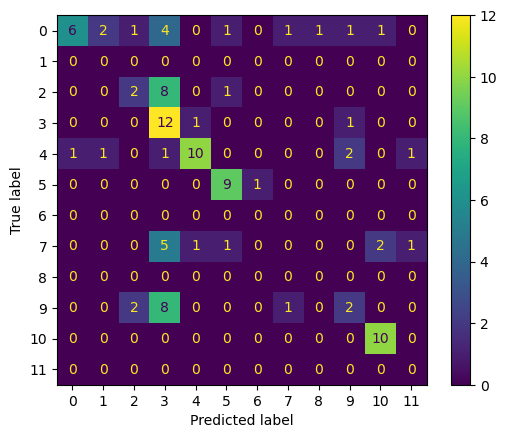

In [75]:
con_mat = confusion_matrix(df["Classification"], df["GPT_Classify"])
cm = ConfusionMatrixDisplay(confusion_matrix=con_mat).plot()
cm.figure_.savefig("Reports/Images/ChatGPT_ConfusionMatrix.png")

### Using ChatGPT Model to Build a Question Classifier
Here, a teacher could enter a sample question, and ChatGPT will identify the Computational Thinking Skill being assessed.

In [79]:
my_question = """ 
What will be the output of the following code? int a=5; if a%5==0 System.out.println("Even")
"""
prompt_part2 = """For each possible class, please give the probability the question should be categorized in that class.  Only answer in the form (class, probability).  For example
(1.B, 0.92), (2.A, 0.04), (2.B, 0.01), (2.C, 0.01), (2.D, 0.00), (4.A, 0.01), (5.A, 0.01), (5.B, 0.01)"""
gpt_classify(prompt_part2 + my_question)

'(2.B, 0.91), (5.B, 0.05), (1.B, 0.03), (4.A, 0.01), (5.A, 0.00), (2.A, 0.00), (2.C, 0.00), (2.D, 0.00)'

## Summary  
This project had some success at identifying the skills assessed in a particular question.  

1. The classifier using a TF-IDF vectorization accurately identified the Computational Thinking Practice being accessed in 70% of the questions, while the simple classifier using the Sentence Transformed identified the Computational Thinking Practice being assessed in 85% of the questions. 
2. ChatGPT had an accuracy of 48% in identifying the Computational Thinking Practice assessed in a question.
3. A simple tool was developed for identifying the skill assessed by a question 

### Next Steps:
1. Develop better prompts to improve ChatGPT's classification accuracy.
2. Determine whether the classifier can also identify the "Essential Knowledge" assessed by the question, not just the computational skill.
3. Attempt to generalize the classifiers to classify non-assessment questions such as lecture material, lab questions, and homework problems.
4. Create a visualization that shows the distribution of thinking skills and content assessed over the course of the curriculum.